In [152]:
import eda_utils
import importlib
importlib.reload(eda_utils)
import warnings
import pandas as pd
warnings.simplefilter("ignore", pd.errors.PerformanceWarning)

filepaths = [
    "./data/dwd_icon_eu_demand_20200920_20231027.nc",
    "./data/dwd_icon_eu_demand_20231027_20240108.nc",
    "./data/dwd_icon_eu_demand_20240108_20240129.nc",
    "./data/dwd_icon_eu_demand_20240129_20240519.nc"
]

dwd_demand_geo = eda_utils.combine_files(filepaths, agg="coordinates")

file_paths = [
    "./data/ncep_gfs_demand_20200920_20231027.nc",
    "./data/ncep_gfs_demand_20231027_20240108.nc",
    "./data/ncep_gfs_demand_20240108_20240129.nc",
    "./data/ncep_gfs_demand_20240129_20240519.nc"
]

# Aufrufen der automatisierten Funktion
ncep_demand_geo = eda_utils.combine_files(file_paths, agg="coordinates")
ncep_demand_geo = ncep_demand_geo[ncep_demand_geo.longitude < 180]

filepaths = [
    "./data/dwd_icon_eu_hornsea_1_20200920_20231027.nc",
    "./data/dwd_icon_eu_hornsea_1_20231027_20240108.nc",
    "./data/dwd_icon_eu_hornsea_1_20240108_20240129.nc",
    "./data/dwd_icon_eu_hornsea_1_20240129_20240519.nc"
]

dwd_hornsea_geo = eda_utils.combine_files(filepaths, agg='coordinates')

file_paths = [
    "./data/ncep_gfs_hornsea_1_20200920_20231027.nc",
    "./data/ncep_gfs_hornsea_1_20231027_20240108.nc",
    "./data/ncep_gfs_hornsea_1_20240108_20240129.nc",
    "./data/ncep_gfs_hornsea_1_20240129_20240519.nc"
]

# Aufrufen der automatisierten Funktion
ncep_hornsea_geo = eda_utils.combine_files(file_paths, agg='coordinates')

filepaths = [
    "./data/dwd_icon_eu_pes10_20200920_20231027.nc",
    "./data/dwd_icon_eu_pes10_20231027_20240108.nc",
    "./data/dwd_icon_eu_pes10_20240108_20240129.nc",
    "./data/dwd_icon_eu_pes10_20240129_20240519.nc"
]

dwd_pes10_geo = eda_utils.combine_files(filepaths, agg='coordinates')

file_paths = [
    "./data/ncep_gfs_pes10_20200920_20231027.nc",
    "./data/ncep_gfs_pes10_20231027_20240108.nc",
    "./data/ncep_gfs_pes10_20240108_20240129.nc",
    "./data/ncep_gfs_pes10_20240129_20240519.nc"
]

# Aufrufen der automatisierten Funktion
ncep_pes10_geo = eda_utils.combine_files(file_paths, agg='coordinates')
ncep_pes10_geo = ncep_pes10_geo[ncep_pes10_geo.longitude < 180]

dwd_demand_only_coordinates = dwd_demand_geo.groupby(["longitude", "latitude"], as_index=False).mean()
ncep_demand_only_coordinates = ncep_demand_geo.groupby(["longitude", "latitude"], as_index=False).mean()
dwd_hornsea_only_coordinates = dwd_hornsea_geo.groupby(["longitude", "latitude"], as_index=False).mean()
ncep_hornsea_only_coordinates = ncep_hornsea_geo.groupby(["longitude", "latitude"], as_index=False).mean()
dwd_pes10_only_coordinates = dwd_pes10_geo.groupby(["longitude", "latitude"], as_index=False).mean()
ncep_pes10_only_coordinates = ncep_pes10_geo.groupby(["longitude", "latitude"], as_index=False).mean()

In [9]:
importlib.reload(eda_utils)

eda_utils.plot_stations_on_map([dwd_demand_only_coordinates, ncep_demand_only_coordinates, dwd_hornsea_only_coordinates, ncep_hornsea_only_coordinates, dwd_pes10_only_coordinates, ncep_pes10_only_coordinates], ['dwd_demand', 'ncep_demand', 'dwd_hornsea', 'ncep_hornsea', 'dwd_pes10', 'ncep_pes10_geo'])

### __Analyse Windspeed__

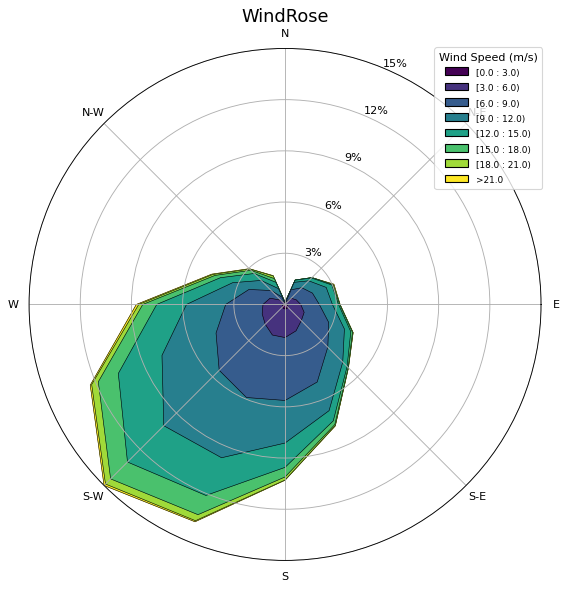

In [274]:
eda_utils.plot_wind_rose(ncep_hornsea_geo, title="WindRose")

### __Analyse WindSpeed per location__

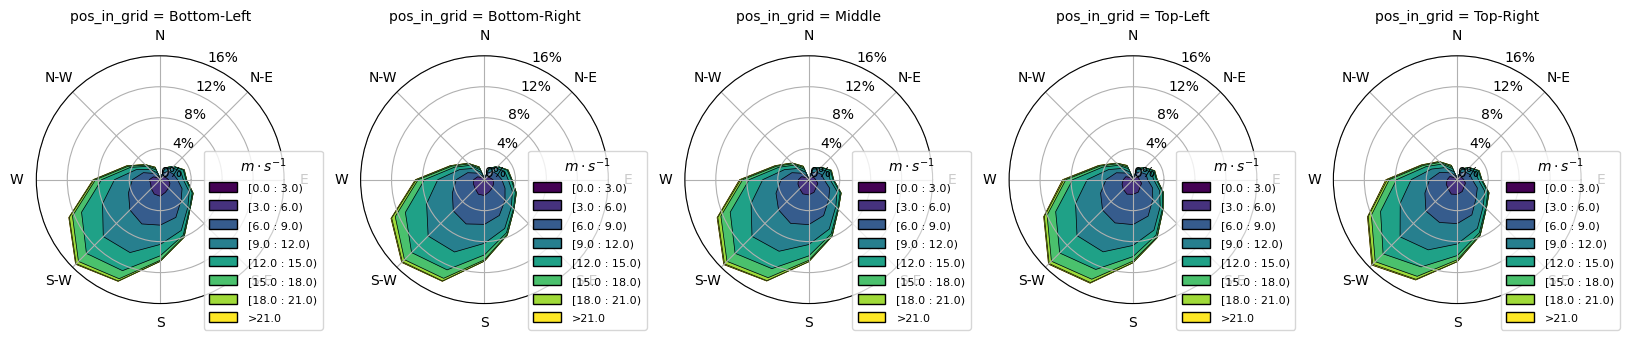

In [329]:
from windrose import WindroseAxes, plot_windrose
import math
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter("ignore", UserWarning)
import seaborn as sns
import matplotlib.ticker as mtick

ncep_hornsea_geo['lat_lon_combination'] = ncep_hornsea_geo['latitude'].astype(str) + '_' + ncep_hornsea_geo['longitude'].astype(str)
corner_pos = ["53.59_1.522", "53.59_2.022", "54.09_2.022", "54.09_1.522", "53.84_1.772"]
plot_df = ncep_hornsea_geo[["latitude","longitude", "valid_time", "WindSpeed:100","WindDirection:100", "lat_lon_combination"]]

plot_df = plot_df[plot_df.lat_lon_combination.isin(corner_pos)]

coordinate_names = {
    "53.59_1.522": "Bottom-Left",
    "53.59_2.022": "Bottom-Right",
    "54.09_2.022": "Top-Right",
    "54.09_1.522": "Top-Left",
    "53.84_1.772": "Middle"
}
plot_df['pos_in_grid'] = plot_df['lat_lon_combination'].map(coordinate_names)


def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction]["mean"], var=data[var]["mean"], ax=ax,  **kwargs)


# this creates the raw subplot structure with a subplot per value in month.
g = sns.FacetGrid(
    data=plot_df,
    # the column name for each level a subplot should be created
    col="pos_in_grid",
    col_wrap=5,
    subplot_kws={"projection": "windrose"},
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5,
)

ws = plot_df['WindSpeed:100']["mean"].to_numpy()
std = np.nanstd(ws)
u = np.nanmean(ws)
width = 3

maxVal = round(u+4*std)
num = math.ceil((maxVal)/width)
maxVal = width*num
if maxVal > 24:
    maxVal = 24

    # Form bin ranges

windRange = np.arange(0, maxVal , width)

g.map_dataframe(
    plot_windrose_subplots,
    direction="WindDirection:100",
    var="WindSpeed:100",
    normed=True,
    # manually set bins, so they match for each subplot
    bins=windRange,
    #opening=0.85,
    linewidth=0.5, 
    #edgecolor='black',
    kind="contourf",
    cmap=cm.viridis
)

g.map_dataframe(
    plot_windrose_subplots,
    direction="WindDirection:100",
    var="WindSpeed:100",
    normed=True,
    # manually set bins, so they match for each subplot
    bins=windRange,
    #opening=0.85,
    linewidth=0.5, 
    colors="black",
    kind="contour",
)

# make the subplots easier to compare, by having the same y-axis range
y_ticks = range(0, 17, 4)
for ax in g.axes:
    ax.set_legend(
        title=r"$m \cdot s^{-1}$", bbox_to_anchor=(1.15, -0.1), loc="lower right"
    )
    ax.set_rgrids(y_ticks, y_ticks)
    fmt = '%.0f%%' 
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

# adjust the spacing between the subplots to have sufficient space between plots
plt.subplots_adjust(wspace=-0.2)

### __Ausfall Energie_Produktion__

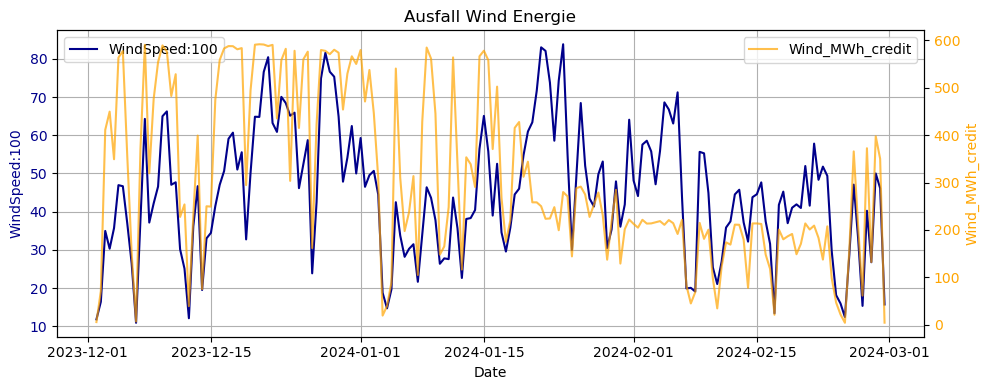

In [344]:
import matplotlib.pyplot as plt
from datetime import date


merged_hornsea = pd.read_parquet("./data/preprocessed_hornsea_with_energy.parquet")
merged_hornsea_simple = merged_hornsea[["wind_speed_100", 'Wind_MWh_credit']]
merged_hornsea_simple = merged_hornsea_simple.resample("12h").mean()
start_date = date(2023, 12, 1)
end_date = date(2024, 3,  1)
plot = merged_hornsea_simple[(merged_hornsea_simple.index.date > start_date) & (merged_hornsea_simple.index.date < end_date)]

fig, ax1 = plt.subplots(figsize=(10, 4))
# Plot the feature on the primary y-axis
ax1.plot(plot.index, plot["wind_speed_100"], color="darkblue", label="WindSpeed:100")
ax1.set_xlabel('Date')
ax1.set_ylabel("WindSpeed:100", color="darkblue")
ax1.tick_params(axis='y', labelcolor="darkblue")

# Create a second y-axis (twinx) for the energy data
ax2 = ax1.twinx()
ax2.plot(plot.index, plot["Wind_MWh_credit"], 'orange', label="Wind_MWh_credit", alpha=0.7)
ax2.set_ylabel("Wind_MWh_credit", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set x-axis labels to display date in a readable format
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax1.grid(True)
ax1.set_title(f'Ausfall Wind Energie')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [352]:
import Preprocessing
import plotly.express as px


extractor = Preprocessing.FileExtractor()

json_data = extractor.extract_json_files("data/REMIT")
preprocesser = Preprocessing.Preprocessing()
outages_df = preprocesser.preprocess_outage_data(json_data)

# px.scatter(outages_df[["affectedUnit", "unavailabilityType"]], color = "unavailabilityType", title = "Ausfallszeiträume der HORNSEA-Windkraftanlagen")